# Задача 7. Нейронные сети

In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from itertools import product

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

train_dataset = SVHN(
    root="~/Desktop/data", 
    split='train', 
    download=True, 
    transform=transform)

test_dataset = SVHN(
    root="~/Desktop/data", 
    split='test', 
    download=True, 
    transform=transform)

100%|██████████| 182M/182M [01:39<00:00, 1.83MB/s] 
100%|██████████| 64.3M/64.3M [00:27<00:00, 2.37MB/s]


In [3]:
trainloader = DataLoader(train_dataset, batch_size=32)
testloader = DataLoader(test_dataset, batch_size=32)

In [4]:
images, labels = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..-0.10588235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..-0.11372548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..0.3411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4352941..0.3176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6862745..0

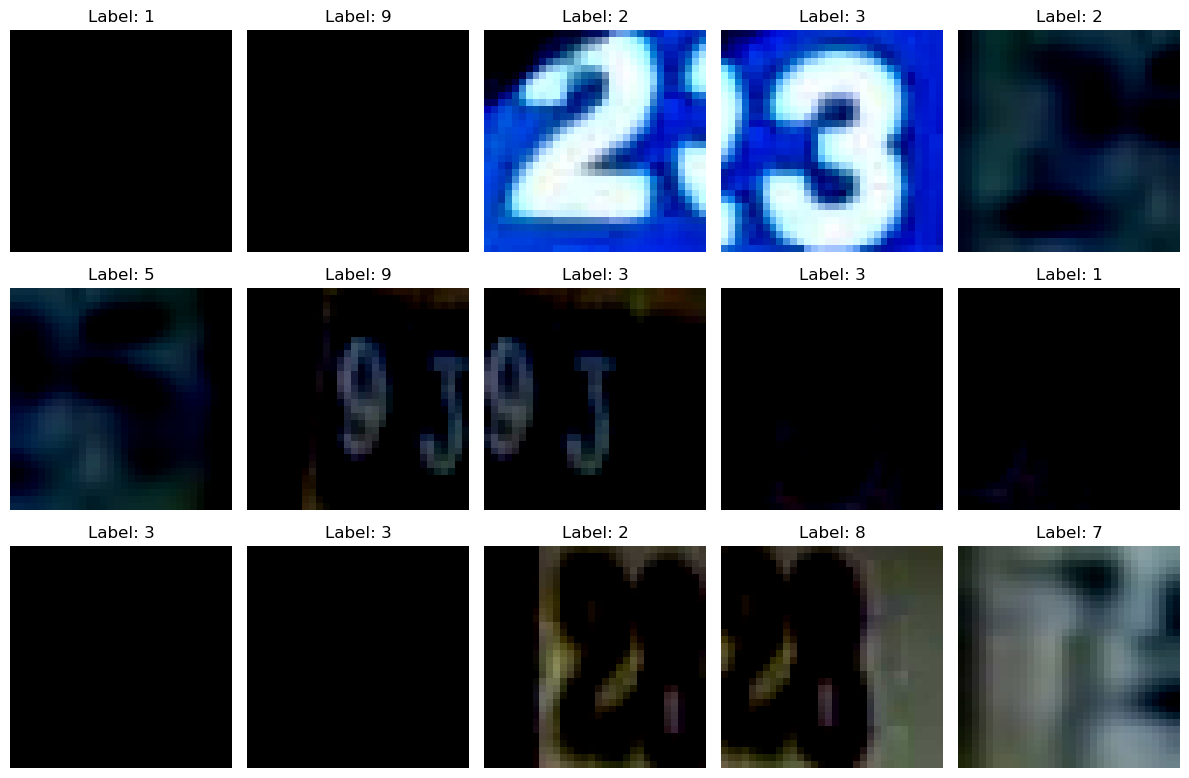

In [5]:
def show_images(images, labels, nrows=3, ncols=5):
    plt.figure(figsize=(12, 8))
    images = images.detach().cpu()
    
    for i in range(min(nrows*ncols, len(images))):
        plt.subplot(nrows, ncols, i+1)

        img = images[i]
        
        if img.shape[0] == 1: 
            img = img.squeeze(0).numpy()
            cmap = 'gray'
        elif img.shape[0] == 3: 
            img = img.permute(1, 2, 0).numpy()
            cmap = None
        else:
            raise ValueError(f"fail to read ing with shape {img.shape}")
        
        plt.imshow(img, cmap=cmap)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images, labels)

### Нейронная сеть

In [6]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * torch.sqrt(torch.tensor(1.0 / in_features)))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        self.x = x
        return torch.matmul(x, self.weight) + self.bias 


class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return F.relu(x)
    
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=128, batch_normalization=False):
        super().__init__()
        self.batch_normalization = batch_normalization

        self.fc1 = FullyConnectedLayer(3*32*32, hidden_size)
        self.relu1 = ReluLayer() 
        self.bn1 = nn.BatchNorm1d(hidden_size) if batch_normalization else None
        self.fc2 = FullyConnectedLayer(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = self.relu1(x)
        if self.batch_normalization:
            x = self.bn1(x)
        x = self.fc2(x)
        return x

### Adam Optimizer

In [11]:
class AdamOptimizer:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        self._validate_hyperparameters(lr, betas, eps, weight_decay)
        
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0

        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]

    @staticmethod
    def _validate_hyperparameters(lr, betas, eps, weight_decay):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {betas[1]}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight decay: {weight_decay}")

    def _apply_weight_decay(self, grad, param):
        # L2 регуляризация
        if self.weight_decay != 0:
            grad.add_(param.data, alpha=self.weight_decay)
        return grad

    def _update_moments(self, i, grad):
        self.m[i].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
        self.v[i].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

    def _get_bias_corrected_estimates(self, i):
        m_hat = self.m[i] / (1 - self.beta1 ** self.t)
        v_hat = self.v[i] / (1 - self.beta2 ** self.t)
        return m_hat, v_hat

    def _update_parameters(self, param, m_hat, v_hat):
        param.data.addcdiv_(m_hat, v_hat.sqrt().add(self.eps), value=-self.lr)

    def step(self):
        self.t += 1
        
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
                
            grad = param.grad.data
            
            grad = self._apply_weight_decay(grad, param)
            self._update_moments(i, grad)
            m_hat, v_hat = self._get_bias_corrected_estimates(i)
            self._update_parameters(param, m_hat, v_hat)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

def get_optimizer(name, params, lr, **kwargs):
    optimizers = {
        'adam': lambda: AdamOptimizer(params, lr=lr, **kwargs),
        'sgd': lambda: optim.SGD(params, lr=lr, **kwargs)
    }
    
    return optimizers[name]()

### Обучение с проверкой градиентов


In [13]:
class ModelTrainer:
    def __init__(self, model, 
                 train_loader,
                 test_loader,
                 loss_fn,
                 optimizer):

        self.model = model
        self.train_loader = trainloader
        self.test_loader = testloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': []
        }

    
    def _train_epoch(self):
        self.model.train()
        running_loss = 0.0
        total_samples = 0
        
        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            
            self.optimizer.zero_grad()
            loss.backward()
            
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
        
        return running_loss / total_samples
    
    def _validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in self.test_loader:
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        
        return val_loss / total, correct / total
    
    def train(self, num_epochs: int = 10):
        for epoch in range(num_epochs):
            train_loss = self._train_epoch()
            val_loss, val_acc = self._validate()
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_acc)
            
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_acc:.2%}")
        
        return self.model, self.history


def train_model(model,
               train_loader,
               test_loader,
               loss_fn,
               optimizer,
               num_epochs: int = 10,):
    trainer = ModelTrainer(model, train_loader, test_loader, loss_fn, optimizer)

    return trainer.train(num_epochs)

# Эксперимент


Training NeuralNetwork with lr=0.001, optimizer=adam, batch_norm=False

Epoch 1/5 | Train Loss: 1.2578 | Val Loss: 1.1751 | Val Acc: 64.61%
Epoch 2/5 | Train Loss: 0.8670 | Val Loss: 1.0553 | Val Acc: 69.87%
Epoch 3/5 | Train Loss: 0.7588 | Val Loss: 0.8855 | Val Acc: 75.18%
Epoch 4/5 | Train Loss: 0.6995 | Val Loss: 0.9240 | Val Acc: 74.11%
Epoch 5/5 | Train Loss: 0.6631 | Val Loss: 0.8344 | Val Acc: 77.53%


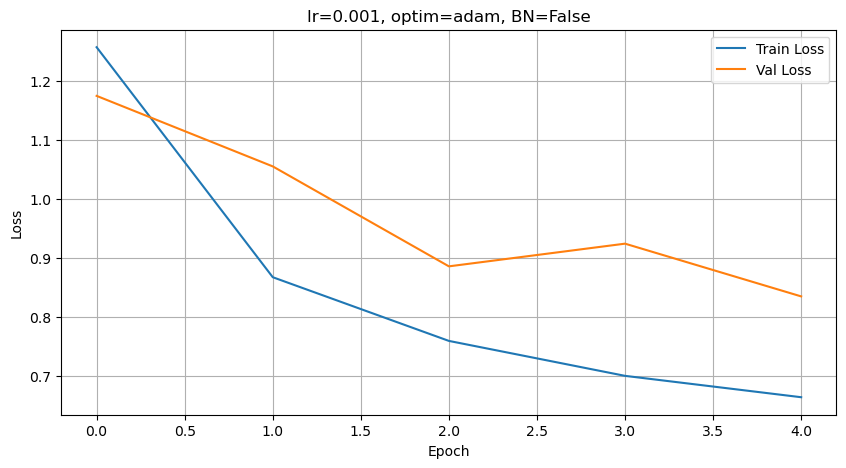


Final results:
Best val accuracy: 77.53%
Final train loss: 0.6631
Final val loss: 0.8344


Training NeuralNetwork with lr=0.001, optimizer=sgd, batch_norm=False

Epoch 1/5 | Train Loss: 2.2118 | Val Loss: 2.1101 | Val Acc: 29.49%
Epoch 2/5 | Train Loss: 2.0467 | Val Loss: 1.9365 | Val Acc: 38.52%
Epoch 3/5 | Train Loss: 1.8670 | Val Loss: 1.7730 | Val Acc: 45.21%
Epoch 4/5 | Train Loss: 1.7059 | Val Loss: 1.6398 | Val Acc: 50.66%
Epoch 5/5 | Train Loss: 1.5718 | Val Loss: 1.5350 | Val Acc: 54.91%


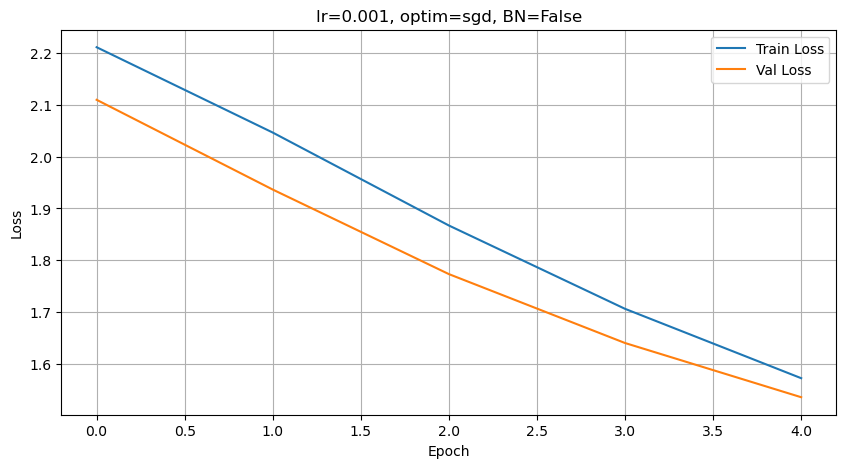


Final results:
Best val accuracy: 54.91%
Final train loss: 1.5718
Final val loss: 1.5350


Training NeuralNetwork with lr=0.01, optimizer=adam, batch_norm=False

Epoch 1/5 | Train Loss: 2.7633 | Val Loss: 2.2887 | Val Acc: 53.11%
Epoch 2/5 | Train Loss: 2.6056 | Val Loss: 3.1940 | Val Acc: 50.23%
Epoch 3/5 | Train Loss: 2.2372 | Val Loss: 3.1499 | Val Acc: 50.69%
Epoch 4/5 | Train Loss: 2.2506 | Val Loss: 3.2759 | Val Acc: 52.59%
Epoch 5/5 | Train Loss: 2.1283 | Val Loss: 2.9235 | Val Acc: 53.86%


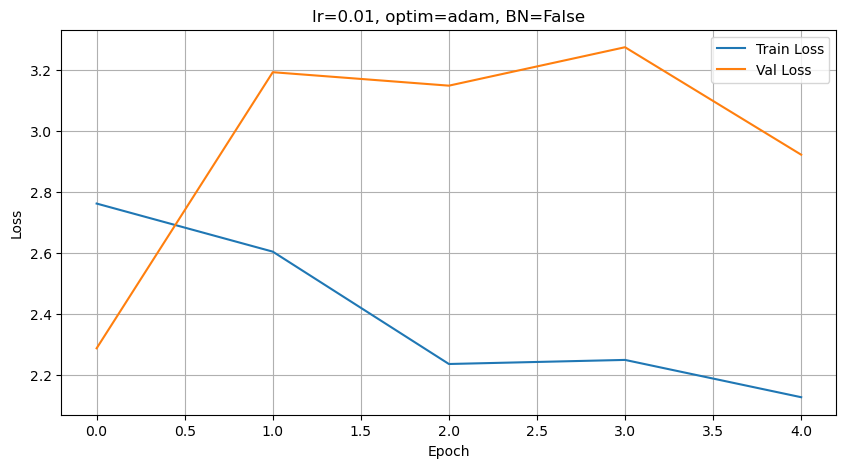


Final results:
Best val accuracy: 53.86%
Final train loss: 2.1283
Final val loss: 2.9235


Training NeuralNetwork with lr=0.01, optimizer=sgd, batch_norm=False

Epoch 1/5 | Train Loss: 1.6036 | Val Loss: 1.2667 | Val Acc: 62.60%
Epoch 2/5 | Train Loss: 1.0784 | Val Loss: 1.0856 | Val Acc: 67.76%
Epoch 3/5 | Train Loss: 0.9282 | Val Loss: 0.9844 | Val Acc: 70.89%
Epoch 4/5 | Train Loss: 0.8387 | Val Loss: 0.9103 | Val Acc: 73.32%
Epoch 5/5 | Train Loss: 0.7717 | Val Loss: 0.8521 | Val Acc: 75.51%


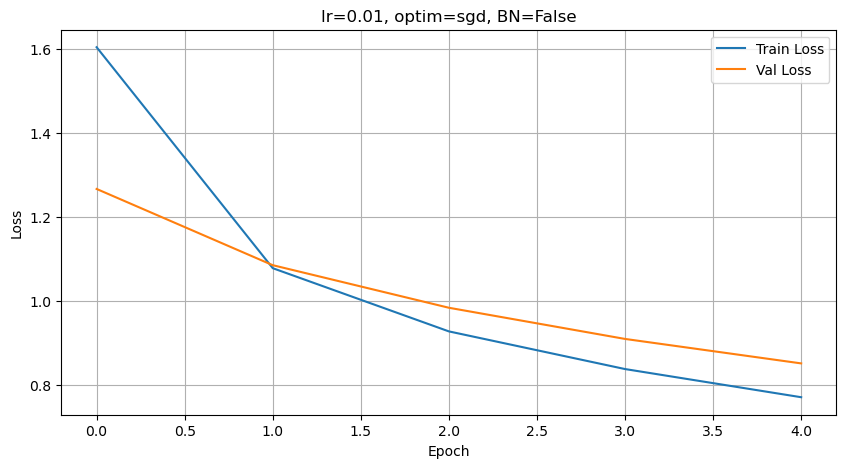


Final results:
Best val accuracy: 75.51%
Final train loss: 0.7717
Final val loss: 0.8521


Training NeuralNetwork with lr=0.001, optimizer=adam, batch_norm=True

Epoch 1/5 | Train Loss: 1.3978 | Val Loss: 1.3425 | Val Acc: 59.38%
Epoch 2/5 | Train Loss: 1.0148 | Val Loss: 1.0551 | Val Acc: 67.82%
Epoch 3/5 | Train Loss: 0.8937 | Val Loss: 0.9686 | Val Acc: 70.82%
Epoch 4/5 | Train Loss: 0.8194 | Val Loss: 0.8584 | Val Acc: 74.64%
Epoch 5/5 | Train Loss: 0.7687 | Val Loss: 0.8974 | Val Acc: 73.35%


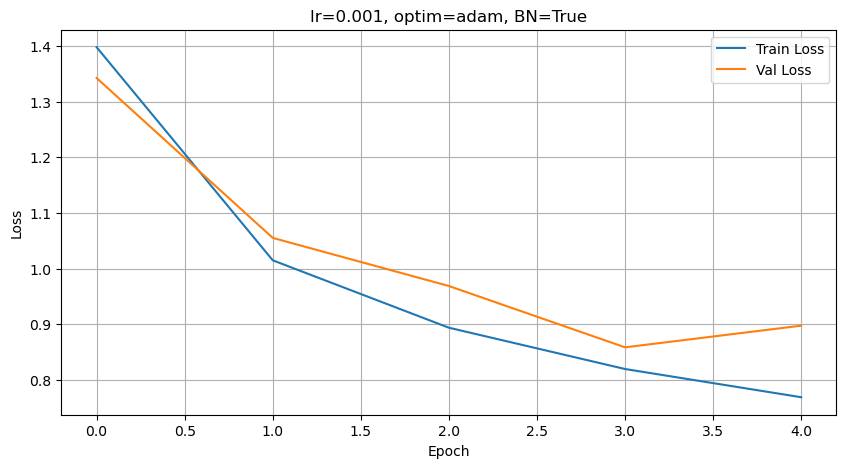


Final results:
Best val accuracy: 74.64%
Final train loss: 0.7687
Final val loss: 0.8974


Training NeuralNetwork with lr=0.001, optimizer=sgd, batch_norm=True

Epoch 1/5 | Train Loss: 1.8580 | Val Loss: 1.5214 | Val Acc: 54.40%
Epoch 2/5 | Train Loss: 1.3380 | Val Loss: 1.2790 | Val Acc: 63.21%
Epoch 3/5 | Train Loss: 1.1617 | Val Loss: 1.1726 | Val Acc: 65.63%
Epoch 4/5 | Train Loss: 1.0624 | Val Loss: 1.1094 | Val Acc: 67.22%
Epoch 5/5 | Train Loss: 0.9925 | Val Loss: 1.0738 | Val Acc: 68.16%


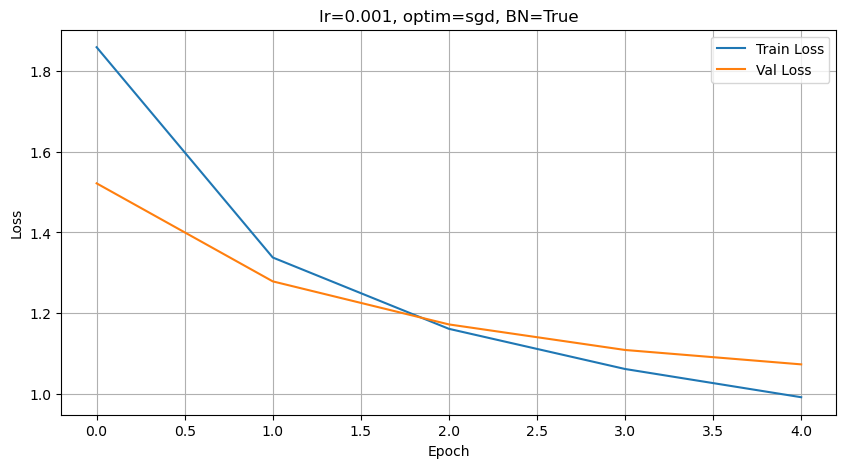


Final results:
Best val accuracy: 68.16%
Final train loss: 0.9925
Final val loss: 1.0738


Training NeuralNetwork with lr=0.01, optimizer=adam, batch_norm=True

Epoch 1/5 | Train Loss: 1.4700 | Val Loss: 1.2808 | Val Acc: 61.06%
Epoch 2/5 | Train Loss: 1.0985 | Val Loss: 1.1058 | Val Acc: 66.73%
Epoch 3/5 | Train Loss: 0.9982 | Val Loss: 1.0711 | Val Acc: 68.04%
Epoch 4/5 | Train Loss: 0.9394 | Val Loss: 0.9782 | Val Acc: 71.29%
Epoch 5/5 | Train Loss: 0.8973 | Val Loss: 0.9412 | Val Acc: 72.50%


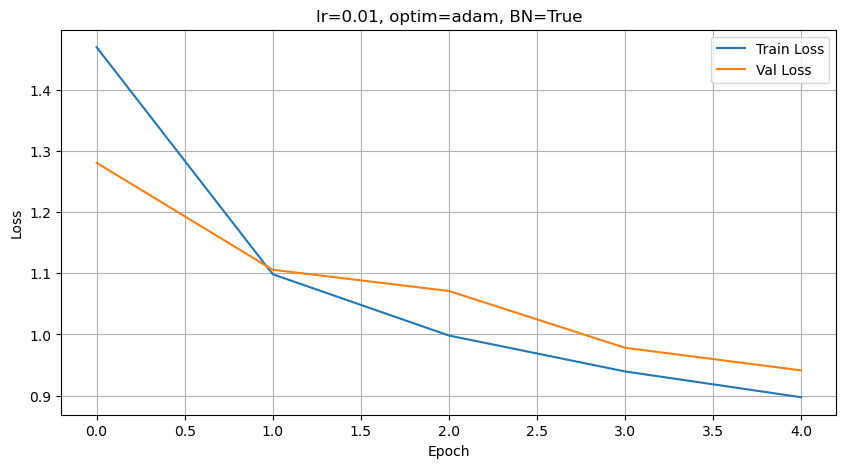


Final results:
Best val accuracy: 72.50%
Final train loss: 0.8973
Final val loss: 0.9412


Training NeuralNetwork with lr=0.01, optimizer=sgd, batch_norm=True

Epoch 1/5 | Train Loss: 1.4367 | Val Loss: 1.2471 | Val Acc: 60.32%
Epoch 2/5 | Train Loss: 1.0238 | Val Loss: 1.1150 | Val Acc: 65.79%
Epoch 3/5 | Train Loss: 0.8904 | Val Loss: 1.0375 | Val Acc: 68.45%
Epoch 4/5 | Train Loss: 0.8152 | Val Loss: 0.8754 | Val Acc: 74.37%
Epoch 5/5 | Train Loss: 0.7648 | Val Loss: 0.8338 | Val Acc: 75.46%


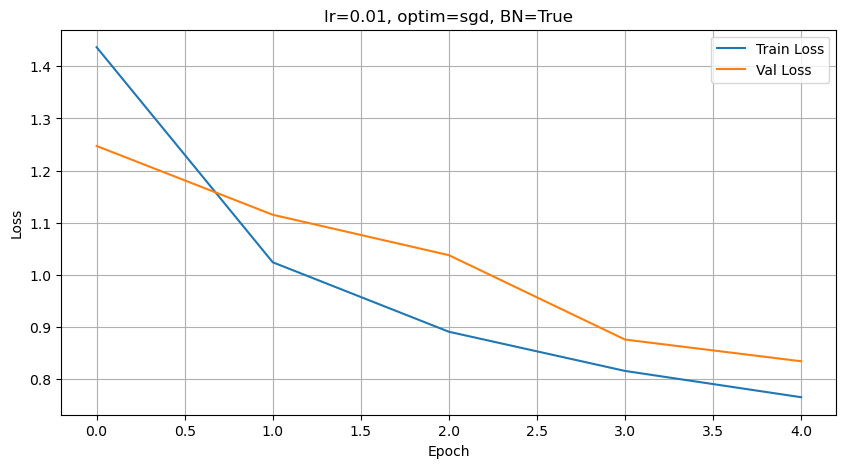


Final results:
Best val accuracy: 75.46%
Final train loss: 0.7648
Final val loss: 0.8338



In [16]:
def run_experiments(models, lrs, optimizers, num_epochs=5):
    torch.manual_seed(42)
    results = []
    
    for model_config, lr, optim_name in product(models, lrs, optimizers):
        model = NeuralNetwork(batch_normalization=model_config['batch_norm'])
        criterion = nn.CrossEntropyLoss()
        optimizer = get_optimizer(optim_name, model.parameters(), lr)

        print(f"\nTraining {model.__class__.__name__} with "
              f"lr={lr}, optimizer={optim_name}, "
              f"batch_norm={model_config['batch_norm']}\n")
        
        trainer = ModelTrainer(
            model=model,
            train_loader=trainloader,
            test_loader=testloader,
            loss_fn=criterion,
            optimizer=optimizer
        )
        
        trained_model, history = trainer.train(
            num_epochs=num_epochs,
        )

        result = {
            'model_config': model_config,
            'lr': lr,
            'optimizer': optim_name,
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_accuracy': history['val_accuracy'],
            'best_val_acc': max(history['val_accuracy'])
        }
        results.append(result)

        plt.figure(figsize=(10, 5))
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f"lr={lr}, optim={optim_name}, BN={model_config['batch_norm']}")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"\nFinal results:")
        print(f"Best val accuracy: {result['best_val_acc']:.2%}")
        print(f"Final train loss: {history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {history['val_loss'][-1]:.4f}\n")
    
    return results

models_config = [
    {'batch_norm': False, 'seed': 42},
    {'batch_norm': True, 'seed': 42}
]
learning_rates = [0.001, 0.01]
optimizers_list = ['adam', 'sgd']

results = run_experiments(
    models=models_config,
    lrs=learning_rates,
    optimizers=optimizers_list,
    num_epochs=5
)